In [1]:
import torch 
from matplotlib import pyplot as plt 
from einops import rearrange
import seaborn as sns 
import os 
import numpy as np
import io

<Figure size 2000x500 with 0 Axes>

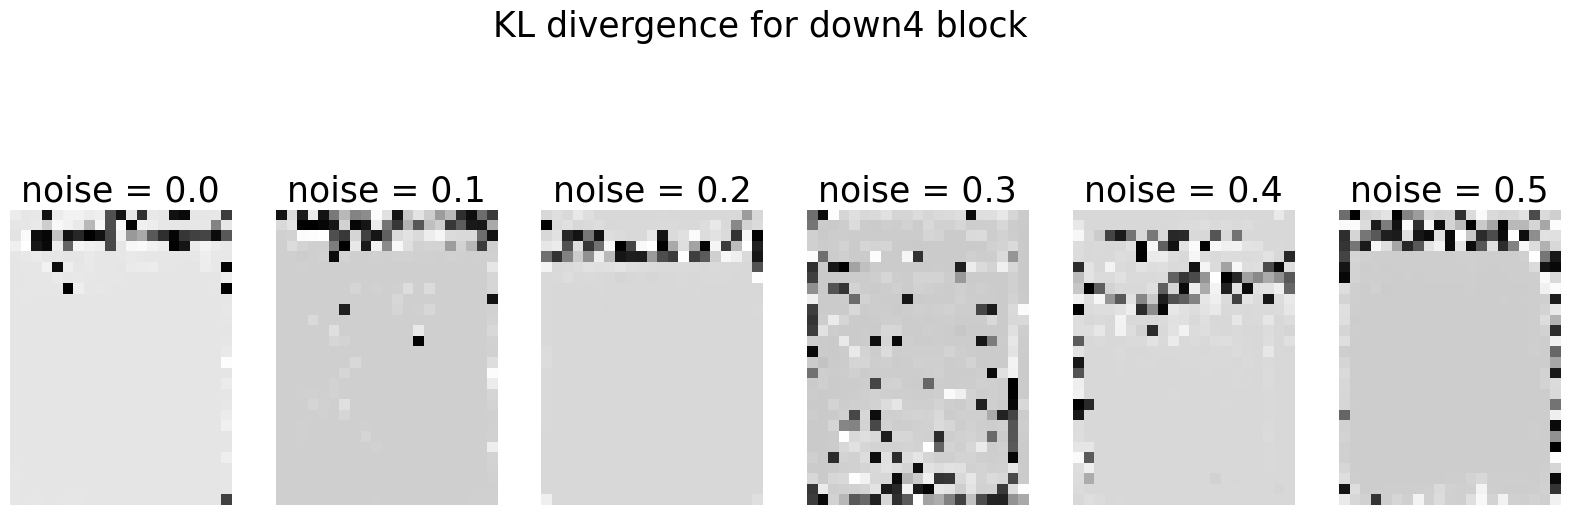

In [2]:
kl_divs = ['down4raw.png']#, 'up1raw.png']
kl_divs = ['down4std.png']#, 'up1norm.png']
plt.figure(figsize=(20, 5))
for kl_div in kl_divs:
    plt.figure(figsize=(20, 5))
    plt.suptitle('KL divergence for {} block'.format(kl_div[:-7]), fontsize=25, y=1.4)
    plt.subplots_adjust(top=1.3)
    plt.tight_layout()
    for i, noise_dir in enumerate(sorted(os.listdir('visualization'))): 
        plt.subplot(1, 6, i+1) 
        plt.title('noise = ' +noise_dir, fontsize=25)
        plt.imshow(plt.imread(os.path.join('visualization', noise_dir, kl_div)), cmap='gray')
        plt.axis('off')
              
    plt.savefig('kl_div_{}.png'.format(kl_div[:-7]), bbox_inches='tight', dpi=300)
    plt.show()

down4/unet_mean.pt: torch.Size([28, 21, 512]), down4/q_unet_mean.pt: torch.Size([28, 21, 512])
down4/unet_mean.pt: torch.Size([28, 21, 512]), down4/q_unet_mean.pt: torch.Size([28, 21, 512])
down4/unet_mean.pt: torch.Size([28, 21, 512]), down4/q_unet_mean.pt: torch.Size([28, 21, 512])
down4/unet_mean.pt: torch.Size([28, 21, 512]), down4/q_unet_mean.pt: torch.Size([28, 21, 512])
down4/unet_mean.pt: torch.Size([28, 21, 512]), down4/q_unet_mean.pt: torch.Size([28, 21, 512])
down4/unet_mean.pt: torch.Size([28, 21, 512]), down4/q_unet_mean.pt: torch.Size([28, 21, 512])


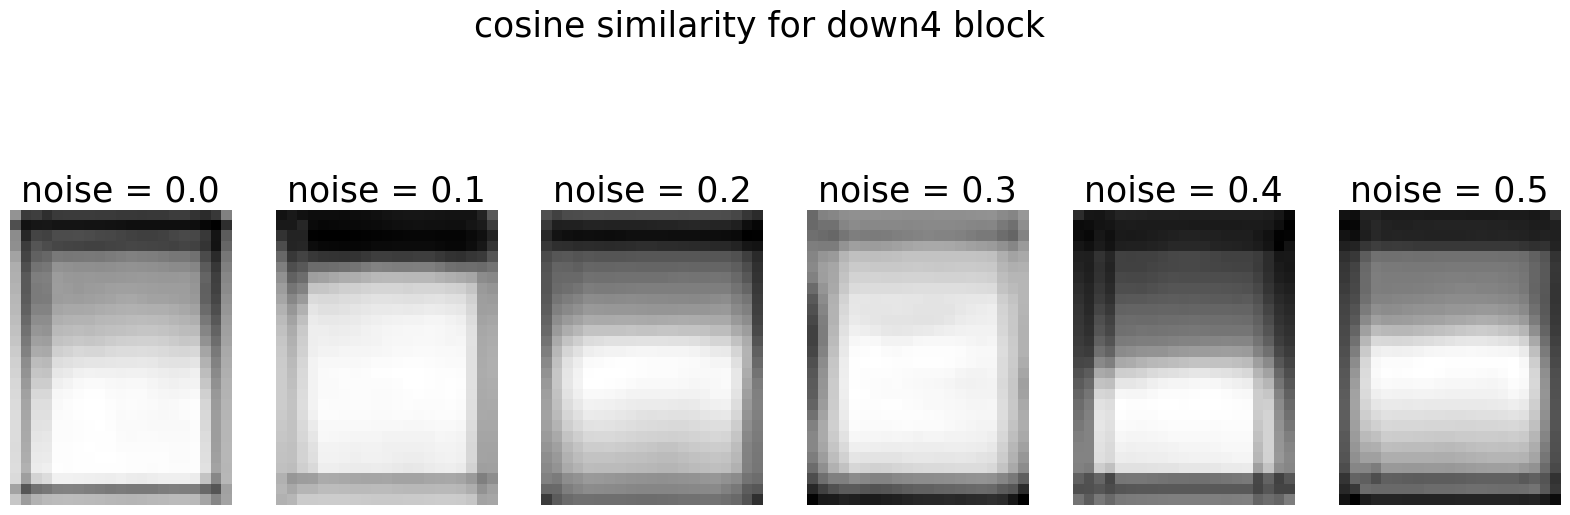

In [3]:
kl_divs = ['down4/unet_mean.pt', 'down4/q_unet_mean.pt']
plt.figure(figsize=(20, 5))
plt.suptitle('KL divergence', fontsize=25, y=1.5)
plt.subplots_adjust(top=1.3)
for i, noise_dir in enumerate(sorted(os.listdir('visualization'))): 
    plt.subplot(1, 6, i+1) 
    plt.suptitle('cosine similarity for down4 block'.format(kl_div[:-7]), fontsize=25, y=1.4)
    plt.subplots_adjust(top=1.3)
    plt.title('noise = ' + noise_dir, fontsize=25)
    unet_mean = torch.load(os.path.join('visualization', noise_dir, kl_divs[0])).cuda()
    q_unet_mean = torch.load(os.path.join('visualization', noise_dir, kl_divs[1])).cuda()
    print(f'{kl_divs[0]}: {unet_mean.shape}, {kl_divs[1]}: {q_unet_mean.shape}')
    unet_mean = unet_mean/torch.norm(unet_mean, dim=-1, keepdim=True)
    q_unet_mean = q_unet_mean/torch.norm(q_unet_mean, dim=-1, keepdim=True)
    cos_sim = unet_mean * q_unet_mean 
    cos_sim = torch.sum(cos_sim, dim=-1)
    plt.imshow(cos_sim.cpu(), cmap='gray')
    plt.axis('off')
plt.savefig('cosine_similarity_{}.png'.format(kl_divs[0].split('/')[0]), bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
from torch import nn 
from unet import UpBlock, DownBlock, DoubleConv, Q_Conv2d



class Q_UNET(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, n_qubits=28, bilinear=True):
        super().__init__() 
        self.n_qubits = n_qubits
        self.ch = DoubleConv(in_ch, 64)
        self.down1 = DownBlock(64, 128)
        self.down2 = DownBlock(128, 256)
        self.down3 = DownBlock(256, 512)
        self.qml_encoder = nn.Sequential(nn.Conv2d(512, 1, 1, 1), 
                                         Q_Conv2d(1, 1, 2, 2, num_layers=2),
                                         nn.Conv2d(1, 512, 1, 1))
                                       
        # self.qml_encoder = nn.Conv2d(512, 1, 1, 1)
        # self.qml_lay = Quanv(n_qubits, n_qubits)
        # self.qml_decoder = nn.Conv2d(1, 512, 1, 1)
        factor = 2 if bilinear else 1
        self.down4 = DownBlock(512, 1024//factor)

        self.up1 = UpBlock(1024, 512//factor, bilinear)
        self.up2 = UpBlock(512, 256//factor, bilinear)
        self.up3 = UpBlock(256, 128//factor, bilinear)
        self.up4 = UpBlock(128, 64, bilinear)
        self.out = nn.Sequential(nn.Conv2d(64, out_ch, kernel_size=1, stride=1),
                                 nn.Sigmoid())

    def forward(self, x, compute: str):
        if compute == 'ip': 
            return x 

        x0 = self.ch(x)
        if compute == 'ch': 
            return x0 

        x1 = self.down1(x0)
        if compute == 'down1': 
            return x1

        x2 = self.down2(x1)
        if compute == 'down2': 
            return x2

        x3 = self.down3(x2)
        if compute == 'down3': 
            return x3

        x = self.down4(x3)
        if compute == 'down4': 
            return x

        x = self.qml_encoder(x)
        print(f'{x.shape = }')
        if compute == 'qml_encoder': 
            return x

        x = self.up1(x, x3)
        if compute == 'up1': 
            return x

        x = self.up2(x, x2)
        if compute == 'up2': 
            return x

        x = self.up3(x, x1)
        if compute == 'up3': 
            return x

        x = self.up4(x, x0)
        if compute == 'up4': 
            return x

        out = self.out(x)
        if compute == 'out': 
            return x

        return out 



In [ ]:
from PIL import Image 
from torchvision import transforms as T
img = Image.open('../samples/im.png')
img = T.ToTensor()(img).unsqueeze(0)    
img.shape 

torch.Size([1, 3, 456, 342])

In [ ]:
model = Q_UNET(3, 1)
logits = model(img, compute='qml_encoder')

x.shape = torch.Size([1, 512, 14, 10])


In [ ]:
kl_div = torch.load('visualization/0.1/down4.pt') 
kl_div.shape

torch.Size([28, 21])

In [22]:
import torch 
from matplotlib import pyplot as plt
import seaborn as sns   
import os
import numpy as np
from tqdm import tqdm

In [23]:
dirs = ['vis_after/{}'.format(str(i)) for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]]
kl_plots = list()
kl_avgs = list()
for idx, dir in enumerate(dirs): 
    kl_div_path = os.path.join(dir, 'down4.pt') 
    kl_div = torch.load(kl_div_path).cpu().numpy() 
    kl_plots.append(kl_div)
    avg = np.mean(kl_div/1e12).round(5)
    kl_avgs.append(avg)


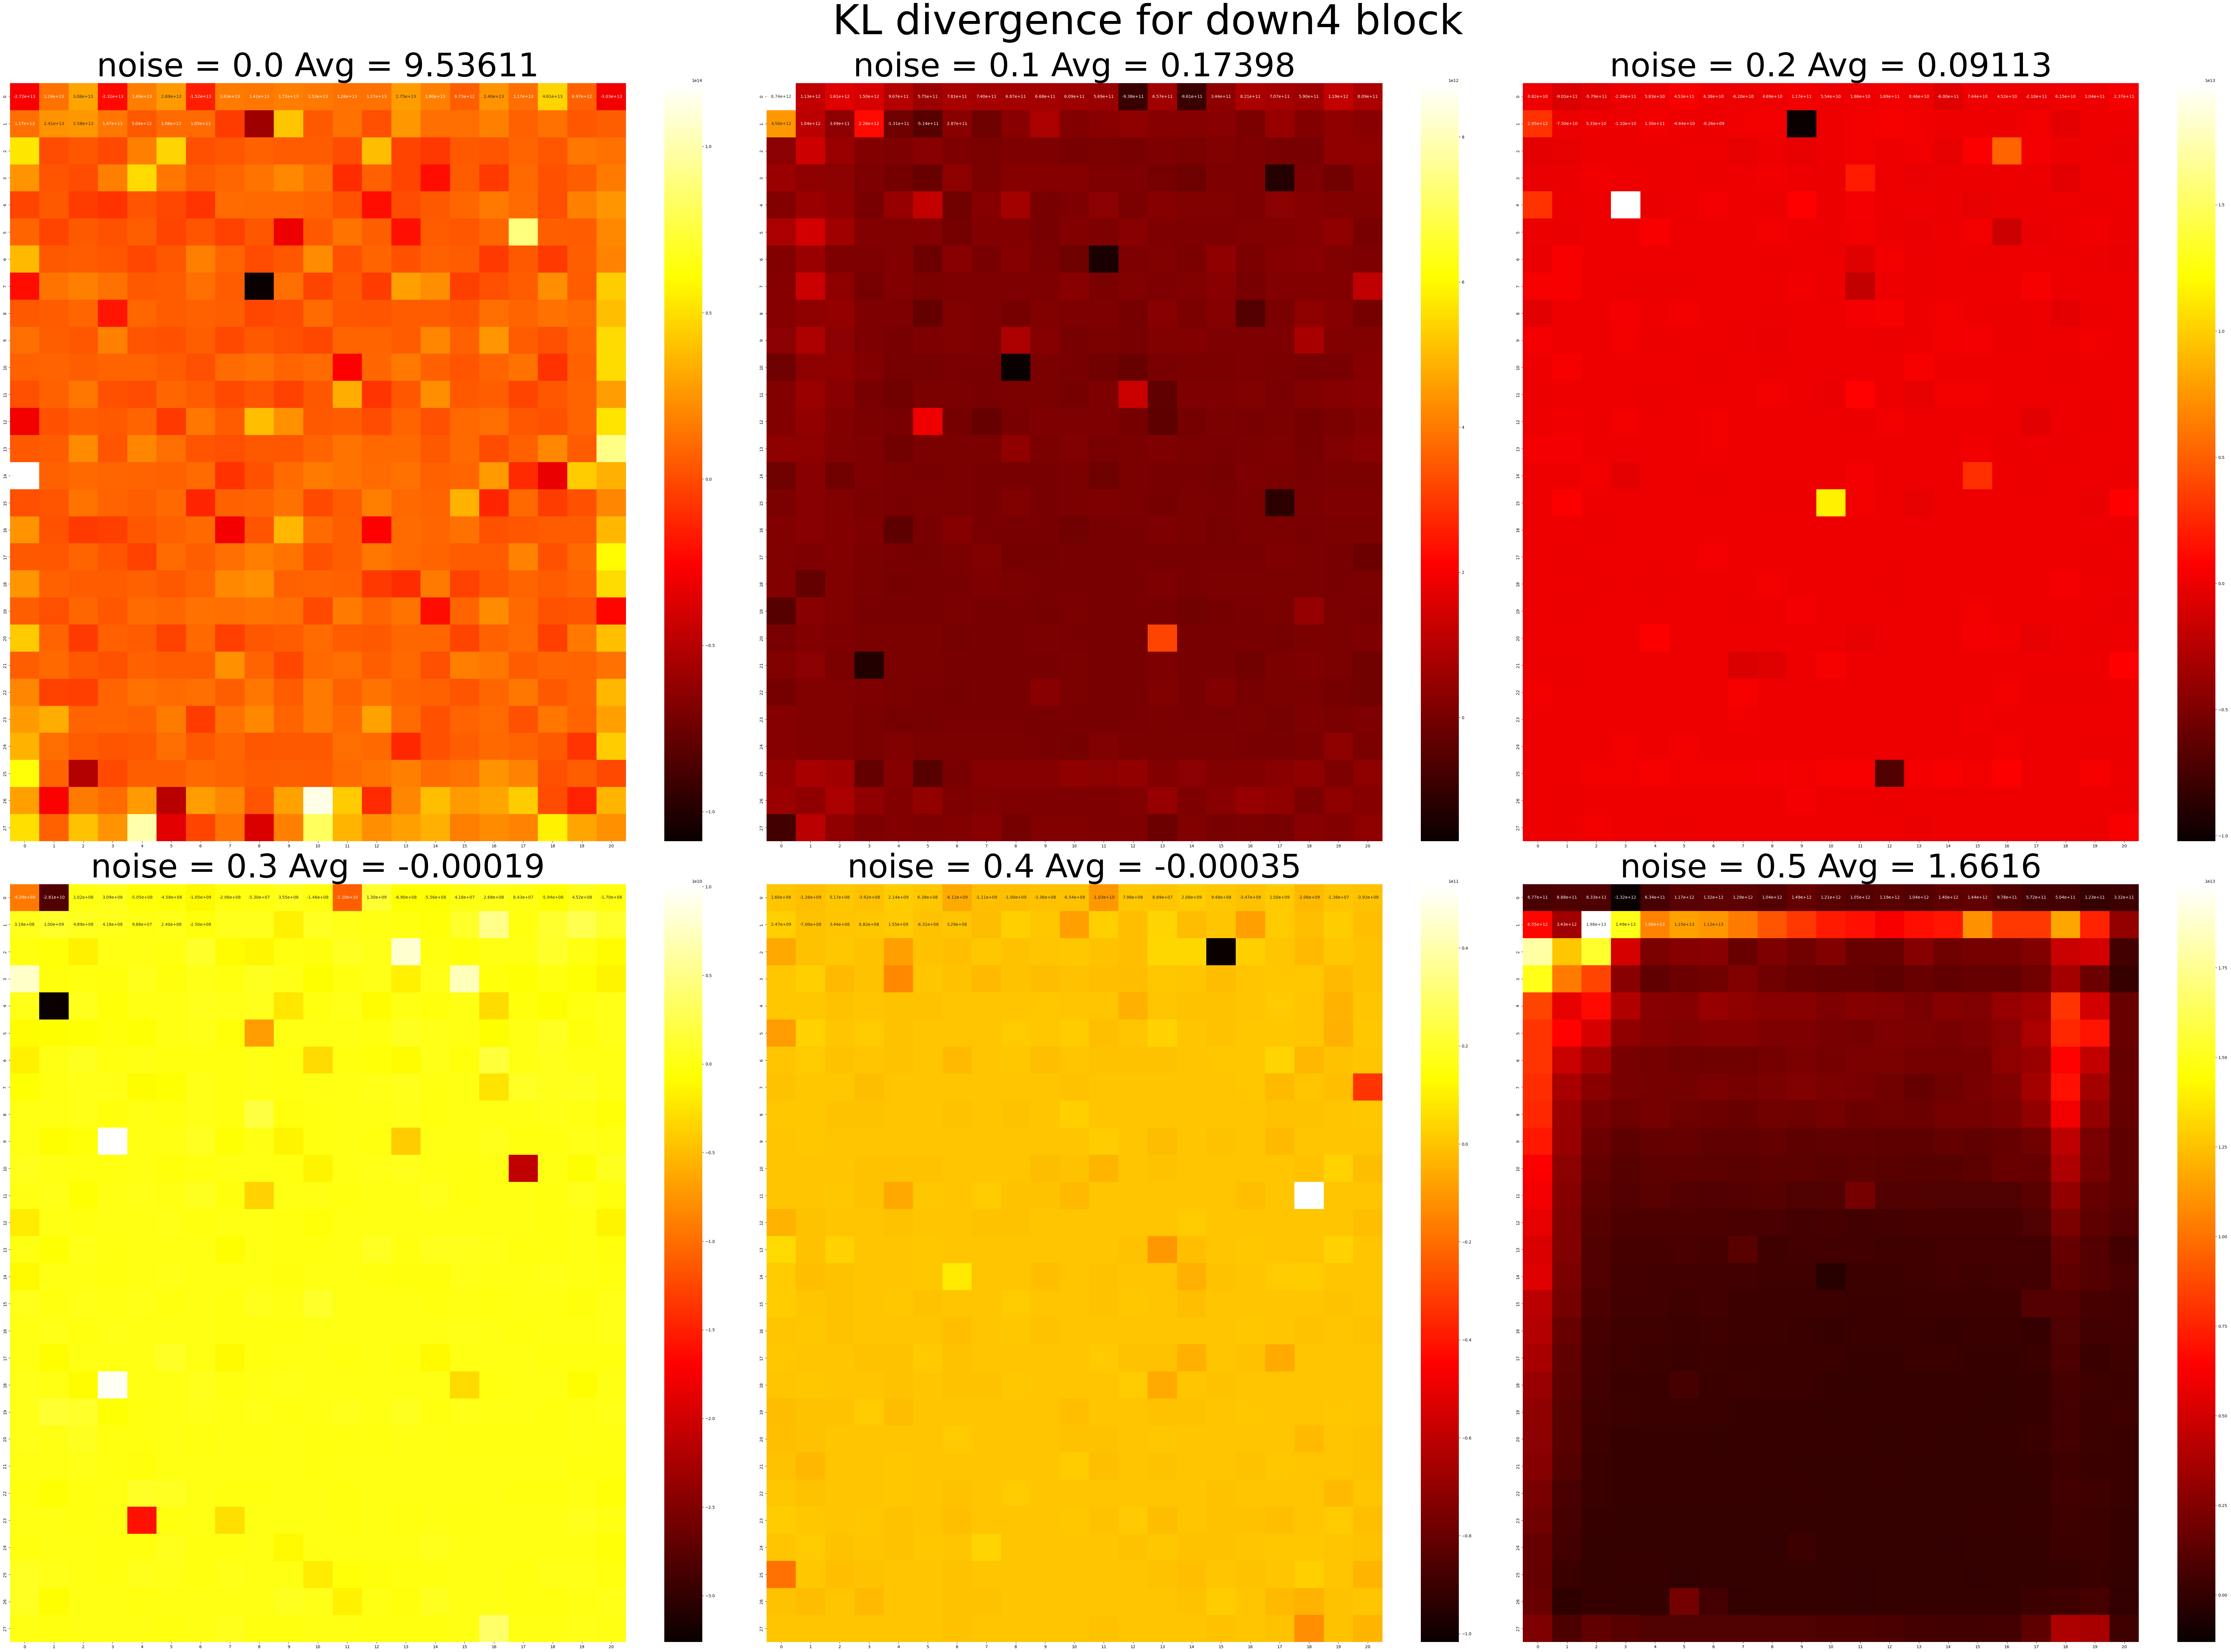

In [24]:
dirs = ['vis_after/{}'.format(str(i)) for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]]
plt.figure(figsize=(3*26, 2*28))
plt.suptitle('KL divergence for down4 block', fontsize=100, y=1)
plt.subplots_adjust(top=1.2)
for idx, dir in enumerate(dirs): 
    plt.subplot(2, 3, idx+1)
    kl_div = kl_plots[idx]
    avg = kl_avgs[idx]
    
    plt.title('noise = {}'.format(dir.split('/')[-1] + ' Avg = ' + str(avg)), fontsize=80)
    sns.heatmap(kl_div, cmap='hot', fmt='.2e', annot=True)
plt.tight_layout()
plt.show()


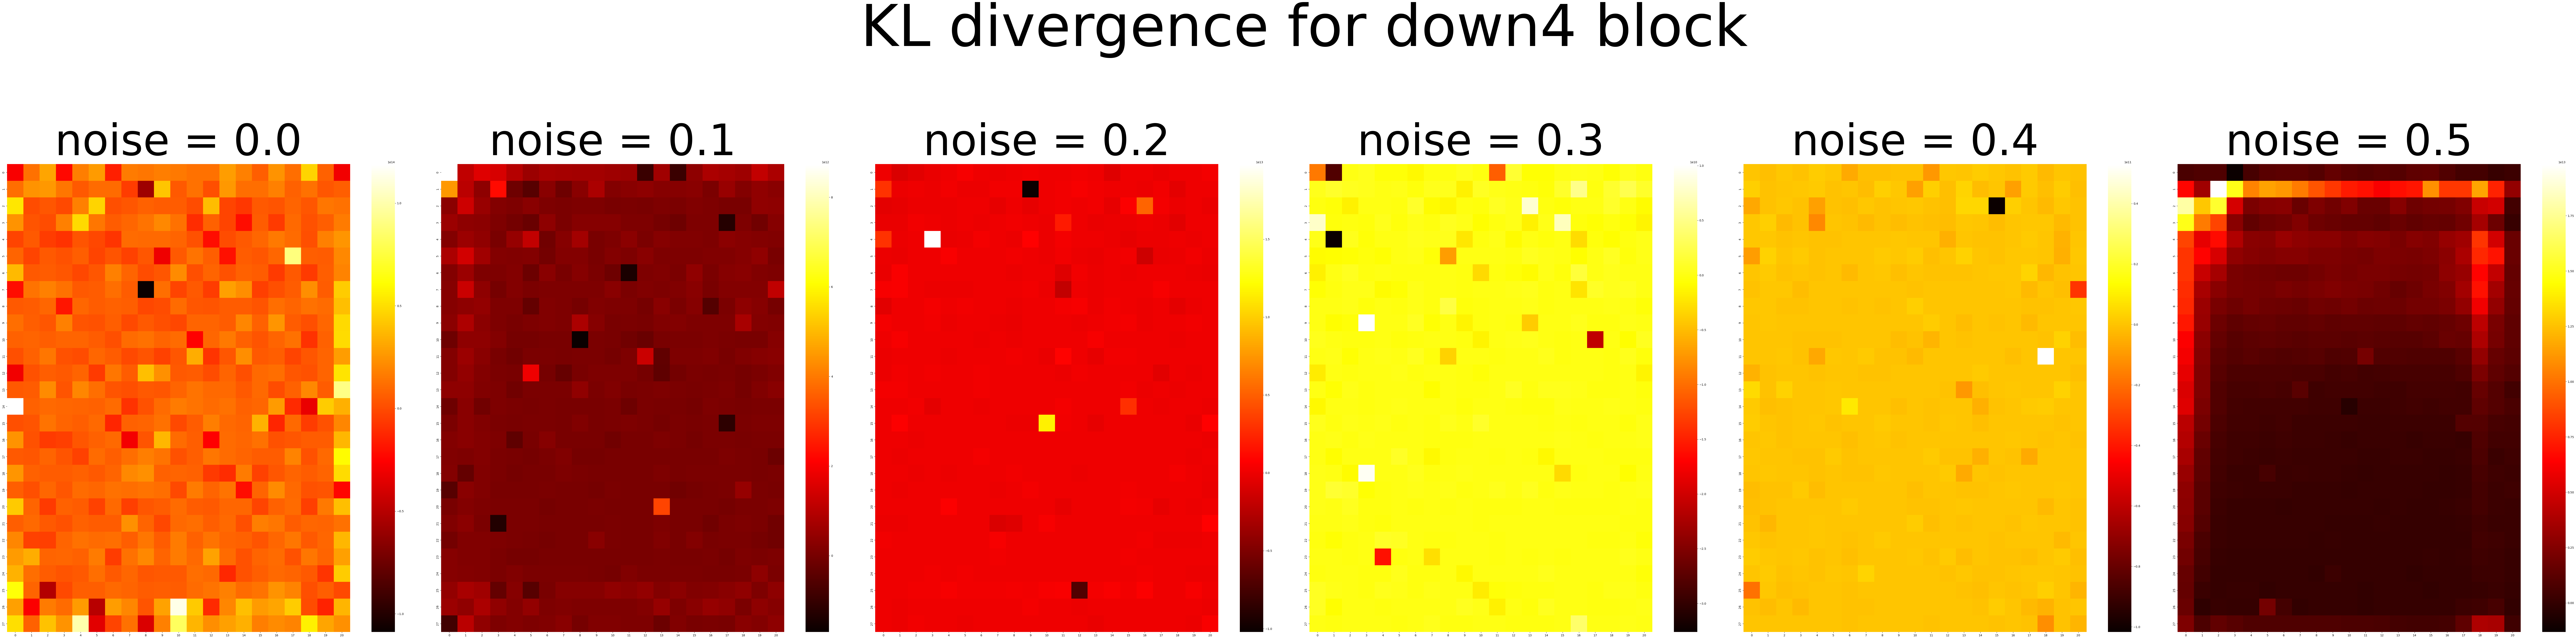

In [25]:
dirs = ['vis_after/{}'.format(str(i)) for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]]
plt.figure(figsize=(21*6, 28))
plt.suptitle('KL divergence for down4 block', fontsize=200, y=1.1)
plt.subplots_adjust(top=1.2)
for idx, dir in enumerate(dirs): 
    plt.subplot(1, 6, idx+1)
    kl_div = kl_plots[idx]
    avg = kl_avgs[idx]
    plt.title('noise = {}'.format(dir.split('/')[-1]), fontsize=150)
    sns.heatmap(kl_div, cmap='hot')
plt.tight_layout()
plt.show()

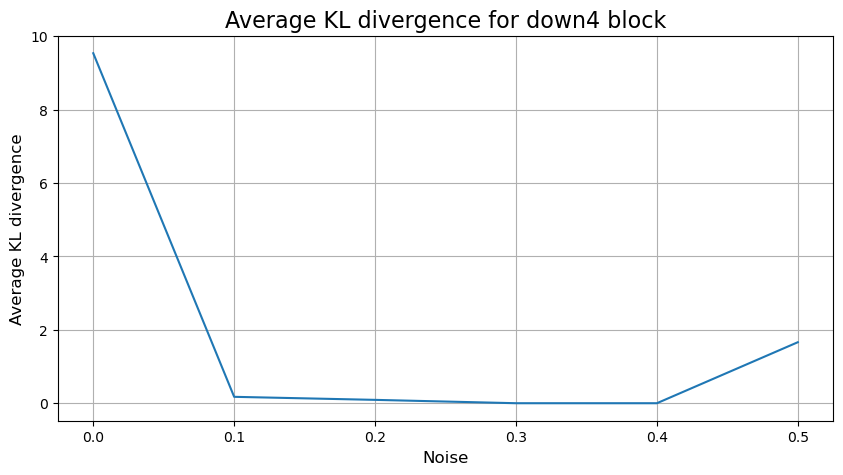

In [26]:
noise = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
plt.figure(figsize=(10, 5))
plt.plot(noise, kl_avgs)
plt.xlabel('Noise', fontsize=12)
plt.ylabel('Average KL divergence', fontsize=12)
plt.title('Average KL divergence for down4 block', fontsize=16)
plt.grid() 
plt.show()

In [27]:
def cos_sim(unet_mean, q_unet_mean): 
    unet_mean = unet_mean/torch.norm(unet_mean, dim=-1, keepdim=True)
    q_unet_mean = q_unet_mean/torch.norm(q_unet_mean, dim=-1, keepdim=True)
    cos_sim = unet_mean * q_unet_mean 
    cos_sim = torch.sum(cos_sim, dim=-1)
    return cos_sim

In [29]:
dirs = ['vis_after/{}/down4'.format(str(i)) for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]]
cos_sims = list()
cos_avgs = list()
for idx, dir in enumerate(dirs): 
    unet_mean_path = os.path.join(dir, 'unet_mean.pt')
    q_unet_mean_path = os.path.join(dir, 'q_unet_mean.pt') 
    cos = cos_sim(torch.load(unet_mean_path), torch.load(q_unet_mean_path))
    cos_sims.append(cos)
    avg = torch.mean(cos).item()
    avg = round(avg, 5)
    cos_avgs.append(avg)



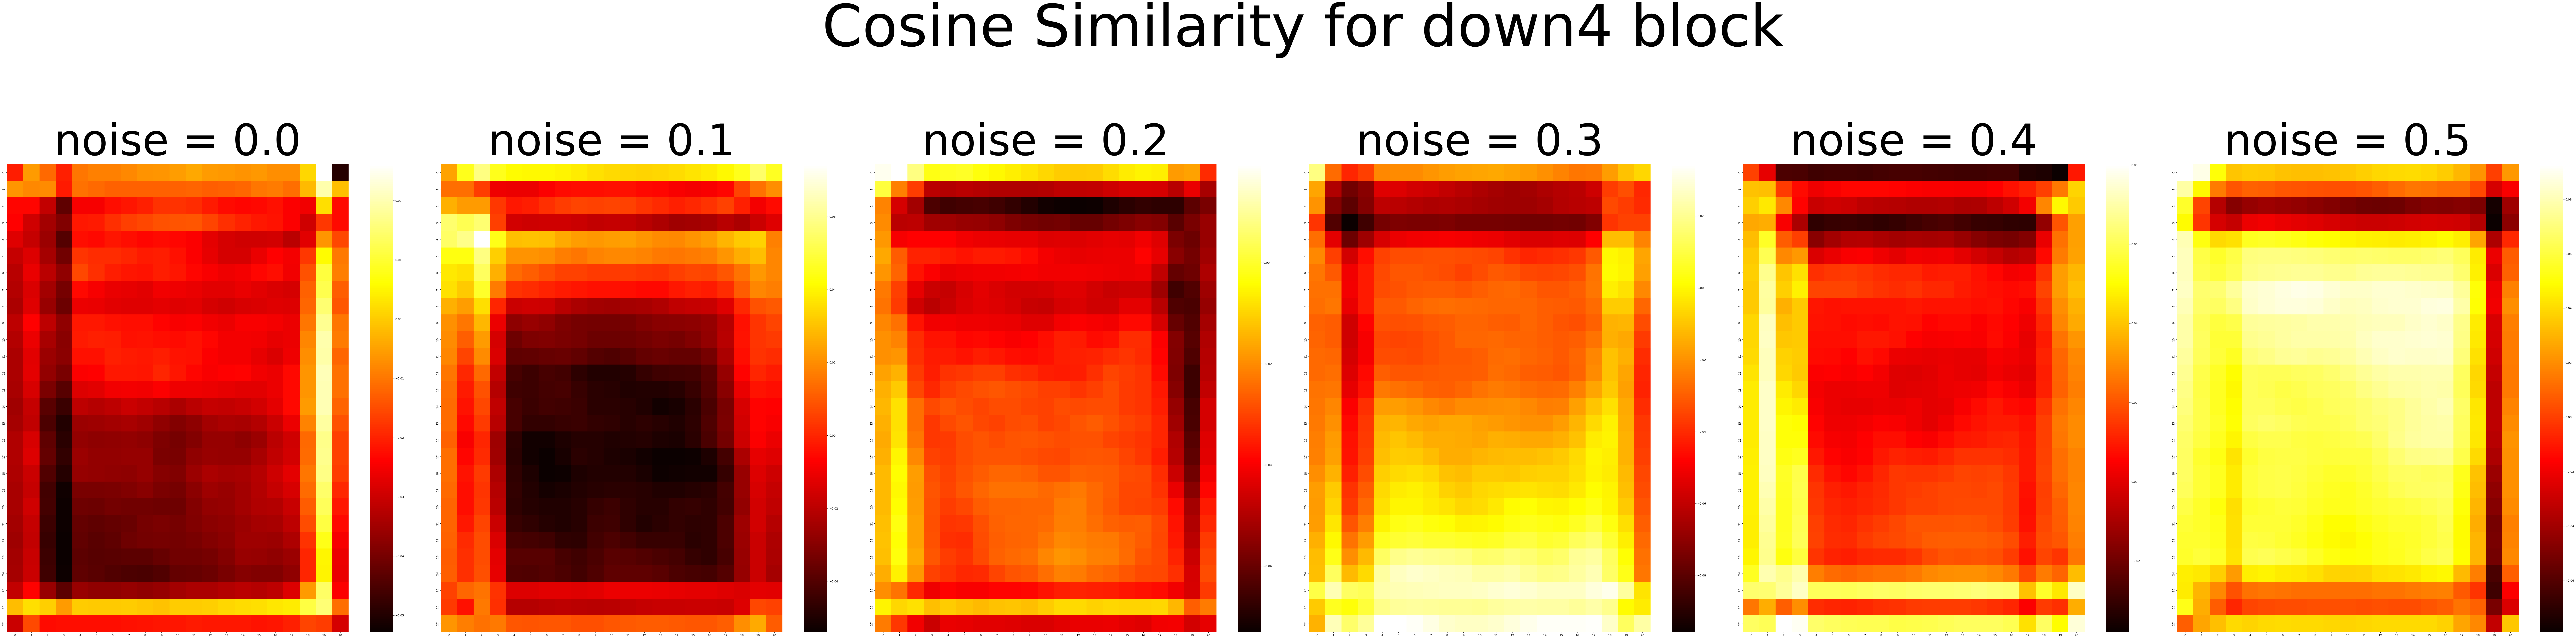

In [30]:
dirs = ['visualization/{}/down4'.format(str(i)) for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]]
plt.figure(figsize=(6*21, 28))
plt.suptitle('Cosine Similarity for down4 block', fontsize=200, y=1.1)
plt.subplots_adjust(top=1.2)
for idx, dir in enumerate(dirs): 
    plt.subplot(1, 6, idx+1)
    cos = cos_sims[idx]
    avg = cos_avgs[idx]
    avg = round(avg, 5) 
    plt.title('noise = {}'.format(str(dir.split('/')[-2] )), fontsize=150)
    sns.heatmap(cos.cpu().numpy(), cmap='hot')
plt.tight_layout()
plt.show()


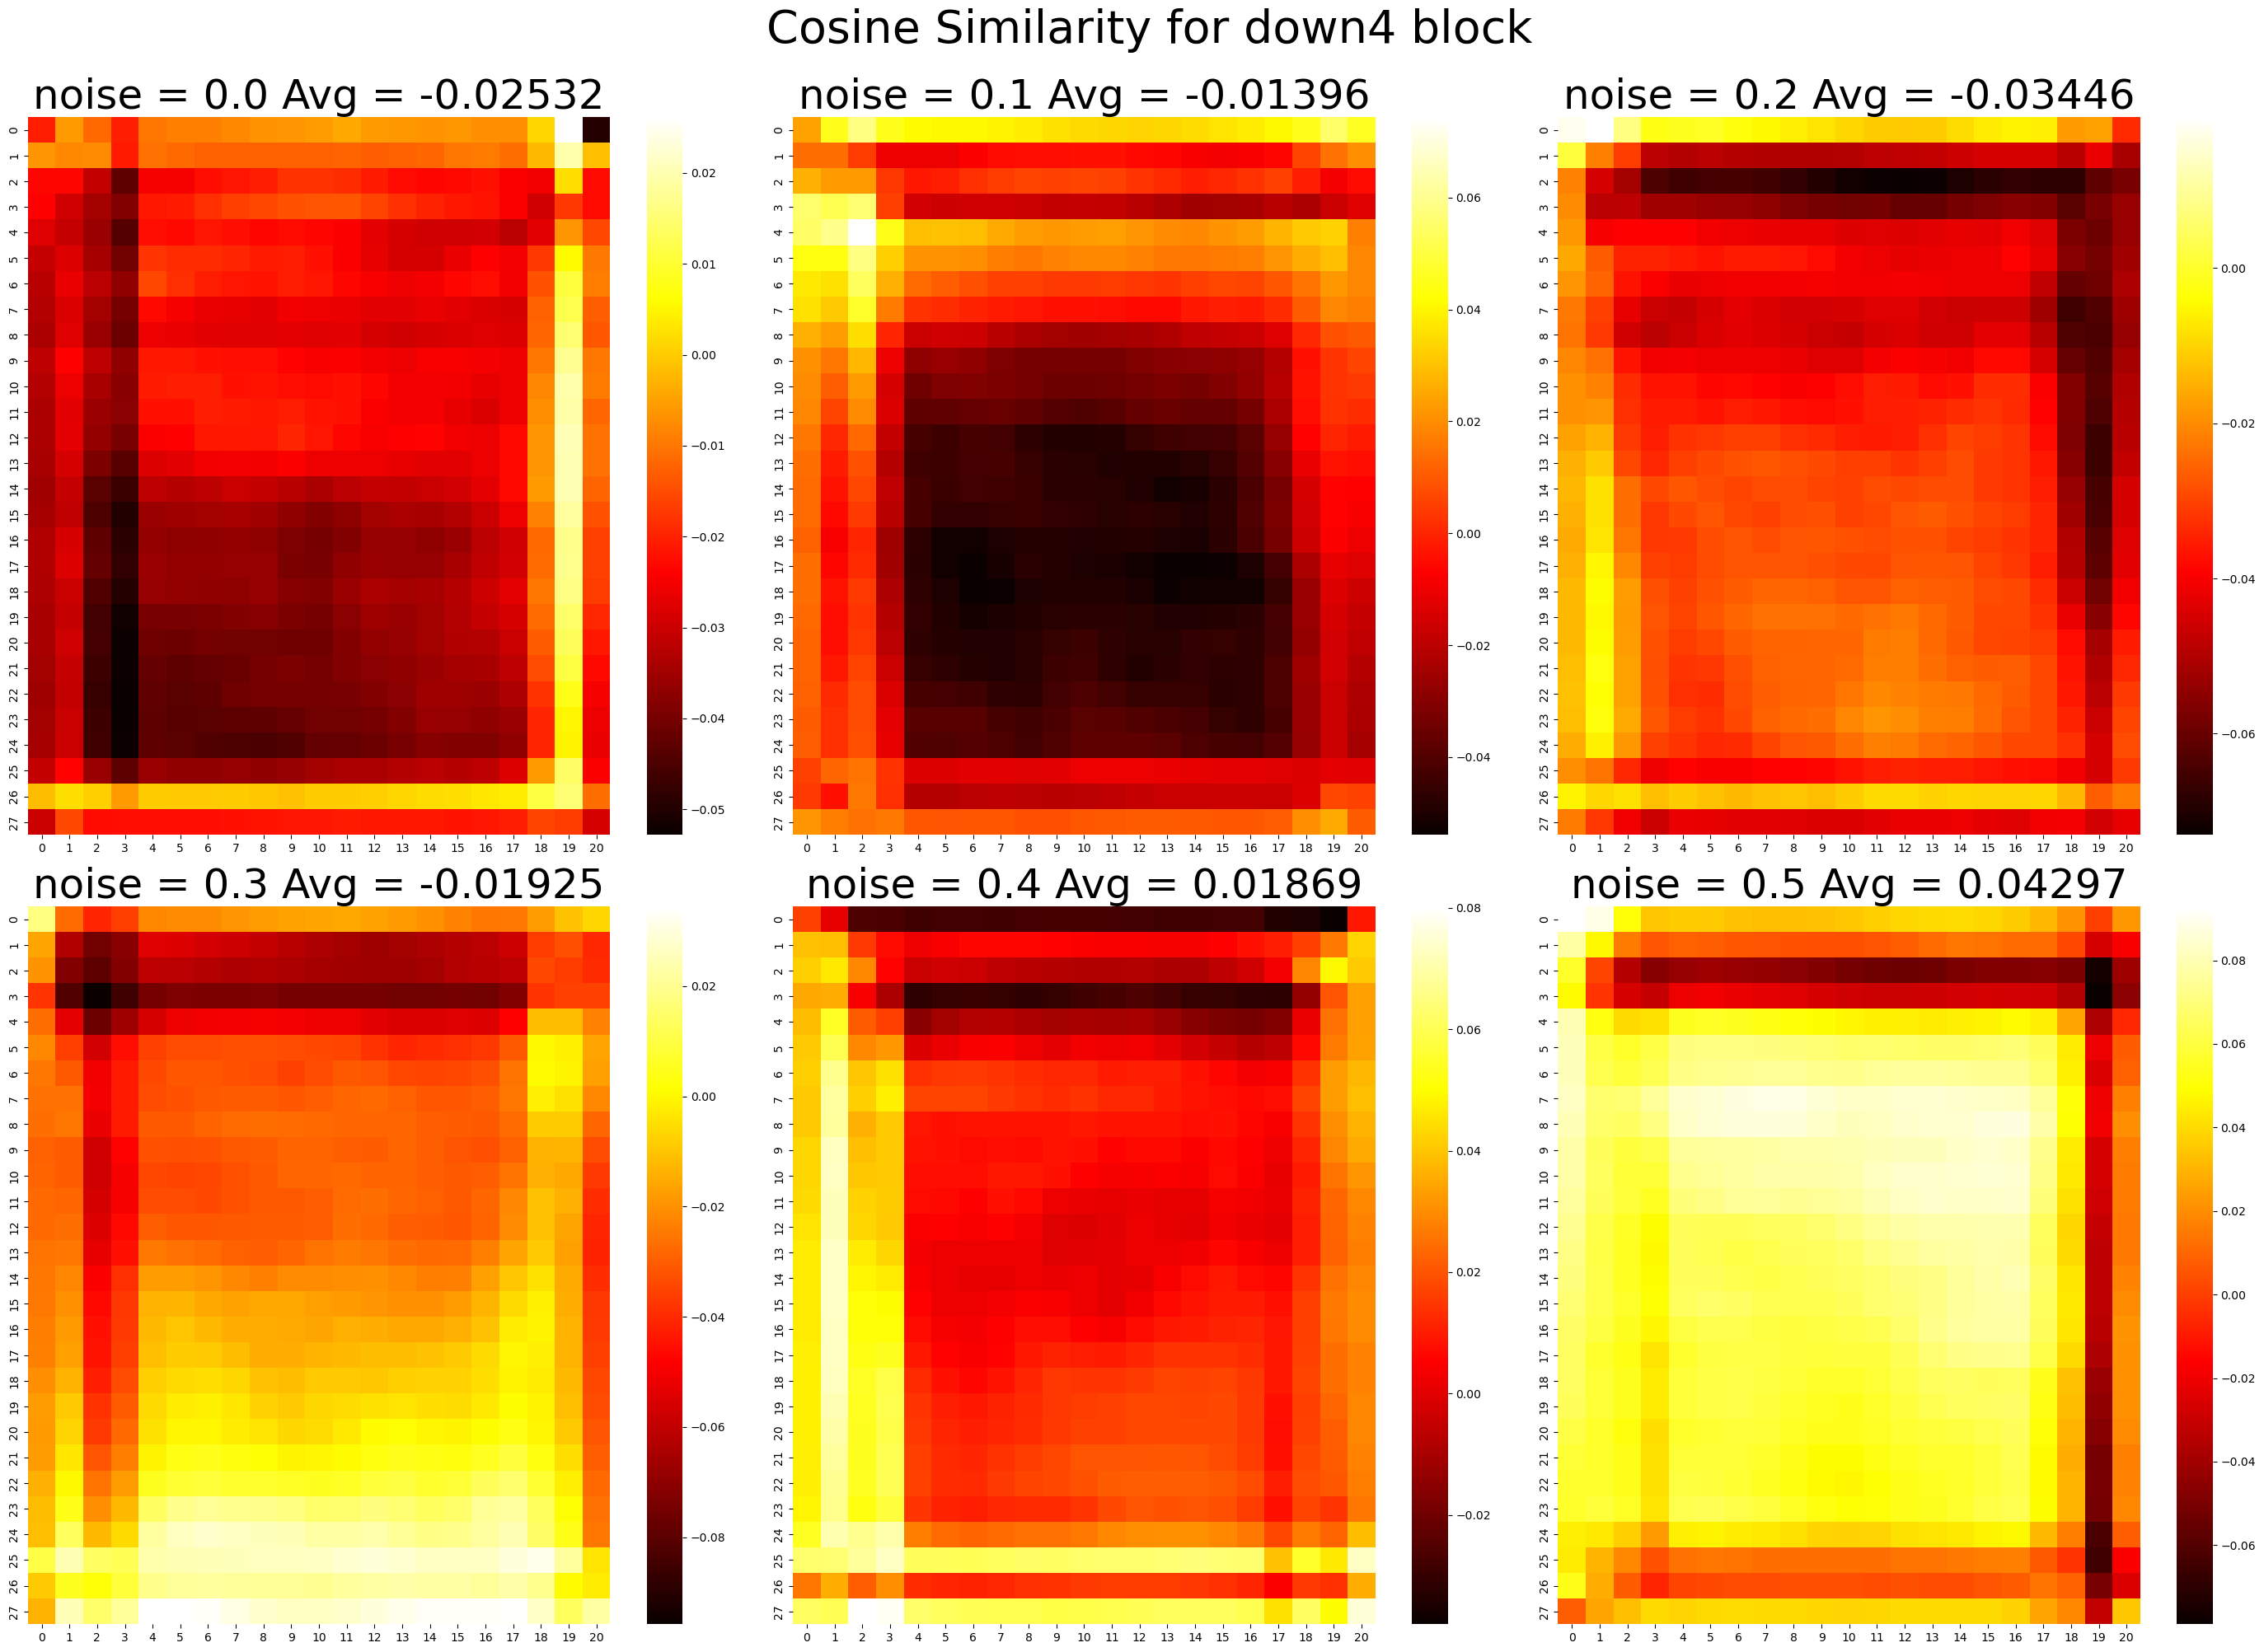

In [31]:
dirs = ['visualization/{}/down4'.format(str(i)) for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]]
plt.figure(figsize=(28, 20))
plt.suptitle('Cosine Similarity for down4 block', fontsize=40, y=1)
plt.subplots_adjust(top=1.2)
for idx, dir in enumerate(dirs): 
    plt.subplot(2, 3, idx+1)
    cos = cos_sims[idx]
    avg = cos_avgs[idx]
    plt.title('noise = {}'.format(str(dir.split('/')[-2] + ' Avg = ' + str(avg))), fontsize=36)
    sns.heatmap(cos.cpu().numpy(), cmap='hot')
plt.tight_layout()
plt.show()


In [32]:
cos_avgs = np.array(cos_avgs)
cos_avgs = (cos_avgs - cos_avgs.min())/(cos_avgs.max() - cos_avgs.min())
kl_avgs = np.array(kl_avgs)
kl_avgs = (kl_avgs - kl_avgs.min())/(kl_avgs.max() - kl_avgs.min())


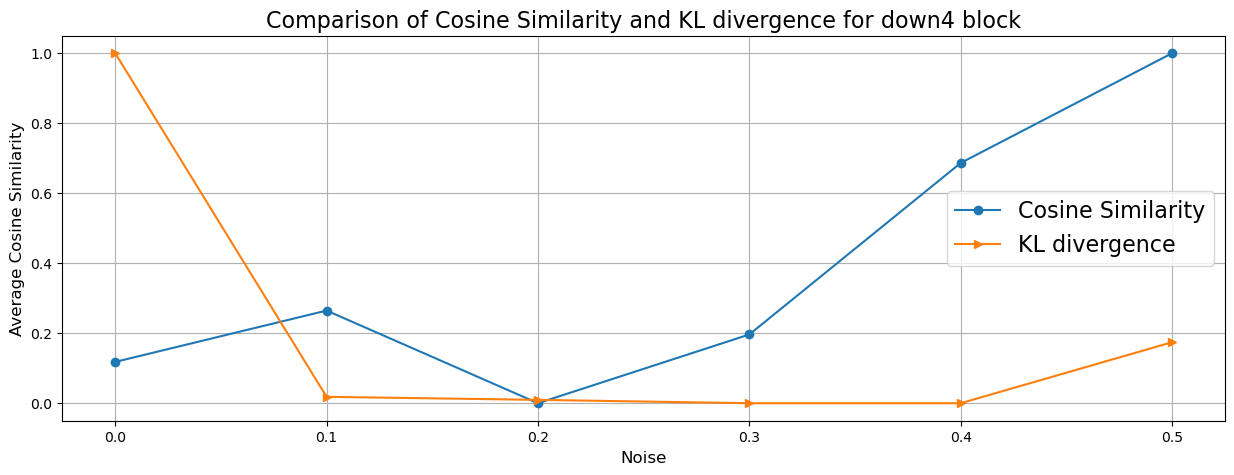

In [33]:
# plt background
# plt.style.use('ggplot')
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(noise, cos_avgs, label='Cosine Similarity', marker='o')
plt.plot(noise, kl_avgs, label='KL divergence', marker='>')
plt.xlabel('Noise', fontsize=12)
plt.ylabel('Average Cosine Similarity', fontsize=12)
plt.title('Comparison of Cosine Similarity and KL divergence for down4 block', fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()

In [43]:
import torch 
from torch import nn 

transformer_encoder = nn.TransformerEncoderLayer(d_model=512, nhead=1, batch_first=True) 
src = torch.rand(10, 32, 512)
pos = torch.ones(32, 32)
output = transformer_encoder(src, pos)
output.shape

torch.Size([10, 32, 512])

torch.Tensor

In [ ]:
transformer_encoder?

Signature:      transformer_encoder(*args, **kwargs)
Type:           TransformerEncoderLayer
String form:   
TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantiz <...> e=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropout(p=0.1, inplace=False)
           )
File:           ~/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py
Docstring:     
TransformerEncoderLayer is made up of self-attn and feedforward network.

This standard encoder layer is based on the paper "Attention Is All You Need".
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
in a different way during application.

TransformerEncoderLayer can handle either traditional torch.tensor inputs,
or Nested Te